In [2]:
# %matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.time import Time
from astropy import units as u
import tqdm
import random
import string
from astropy.visualization import astropy_mpl_style, quantity_support

# Pipeline

### 17th Feb:

**Conditional about observations:**

The user gives the latitude and the functions returns if the phenomenon can be see it or not. This using the conditional "altitude > 0 degrees" but with the difference of taking into account the time of observation on the altitude-Azimuth coordinate system; this is the equivalent ofr the conditional of "dec > 90-latitude".   

Alert system's input format: RA, Dec (hmsdms); Latitude, longitude (DMS); militar hour (hms) using J200 
(Reference: https://ztf.uw.edu/alerts/public/)

**About the sing on the coordinates**
 A positive value for North and East, a negative value for South and West. (Reference: https://tnp.uservoice.com/knowledgebase/articles/172110-latitude-longitude-formats-and-conversion)

### 21th Feb

Now we need to expand the function for a time slot, establish by the user. With this condition, is necesary to report if its observable. An idea is refreshing the dataframe with a nonsmall step, such we can determine if the function is returning what we want. 

Change the scale of time to UTC and keep the format iso for maintain the international format.

Actually, the function Time of astropy simplifies the code because allows sum seconds, hour and minutes in a line.
(Reference: https://docs.astropy.org/en/stable/api/astropy.time.Time.html#astropy.time.Time.FORMATS)

### 24 Feb - 3 Mar
This week have three objectives: 

1) Implement a preference condition, just show the observables and organized with preference of higher altitude. The preference it gonna be a color code:

    Priority: Extraordinary: Green;  High: Orange; Medium: Blue; Low: Pink

2) Try to simulate for see in the time slot only the observables with the observer as the center. First we need to get the coordinates of the observables in the altaz format.

3) Change the enter for a dataframe with the transients information.

### 3 Mar - 9 Mar
This week we redefine the way of give the data required for observation and the priority with the plot of altitude vs time. This lead us to redefine and rewrite the code structure and logic. All for working with time. 

### 10 Mar- 19 Mar
We are gonna try with real data from Stellarium taking random objects of the new general catalogue and the position right Bogotá. But the code don´t go for the graphics, we need to establish another array for the time as the all objects doesnt have the same length. 

And now we have the code for general number of observations.

### 19 Mar
We are gonna try now with random data (literally random) for see haw it goes. And we need to change the order of observation because the limit of observations is the limit for good observations (change two variables).

And we wany to change the format DMS of observer coordinates for degrees just for facilities

### 31 Mar

We change the plot output for 100 and 1000 random positions. 

# General functions

In [3]:
#Made the delta time for the graphic
def DeltaTime(Date_i,Date_f,t_scale):

    scale = t_scale[0]
    sc = t_scale[1]

    a = Time(Date_i,format = 'iso', scale='utc').datetime.hour-24
    b = Time(Date_f,format = 'iso', scale='utc').datetime.hour

    if scale == 's':
        len = int((b-a)/ (sc/3600))
        t_ = np.linspace(a , b , len) 
   
    if scale == 'm':
        len = int((b-a)/ (sc/60))
        t_ = np.linspace(a , b , len)
    
    if scale == 'h':
        len = int((b-a)/ sc)
        t_ = np.linspace(a , b , len)
    
    return t_

#Made the array of time around of midnight
def CreateTime(Date_i,Date_f,t_scale):

    time_midnight = Time( Time(Date_i,format = 'iso', scale='utc').iso.split()[0] + ' 00:00:00' ,format = 'iso', scale='utc')

    delta = DeltaTime(Date_i,Date_f,t_scale)*u.hour

    return time_midnight + delta

#Return the classified observations
def Observations(observer, alert, Date_i, Date_f,time_scale,rango,limit):

    #Definition of different variables:
    time = CreateTime(Date_i,Date_f,time_scale) #return a array

    lat_conv , lon_conv = observer
    observer = EarthLocation(lat=lat_conv*u.deg, lon=lon_conv*u.deg)

    #Lists of data for post-analysis
    Big_Data = []

    #Give the label of identification of each object
    alert['Label'] = range(1, rango)

    #Establish the time slot
    for each_time in time:

        #For each time slot we need the data of the conditional about observations
        
        #Establish the coordinates with the correction from geocentric calculations of astropy
        celestial_coord = SkyCoord(ra=alert['RA'], dec=alert['DEC']) #Mantain the degrees units

        # Calculate the coordenates AltAz for the time and observer and transform the J2000 coordinate system for altaz
        altaz_coord = celestial_coord.transform_to( AltAz(obstime=each_time, location=observer) ) 
    
        # Determinate if its observable and a good observable (altitude > 33 degrees) in the altaz coordinate system, return a boolean.
        state  = altaz_coord.alt > limit*u.deg

        #Put the things together
        alert['Observable'] = state
        alert['Az'] = altaz_coord.az.deg
        alert['Alt'] = altaz_coord.alt.deg
        
        #Put the conditionals of a time slot on a dataframe in the format for better reading
        Data = alert.copy()
        
        #Put the dataframe in a list and the values of time
        Big_Data.append(Data) 

    #With the DataFrame we can organice all the observations
    final_data = pd.concat(Big_Data,axis=0)

    return final_data


#Establish the order, priority and limits for good observations
def EstablishLimits(Data,rango,Time):
    graphic = []
    priority = []
    targets = []

    for i in range(1,rango):
        #Organize and add time to the dataframe
        Target = Data.loc[Data['Label'] == i].copy()
        Target['Time'] = Time

        #Add to the list of graphics the dataframe with the values and time
        graph = Target.copy()
        graph = graph[graph['Observable'] != False]
        graphic.append(graph.drop(['Name','RA','DEC'],axis=1))
        
        #Now that we added to the list, do the priority algorimth
    
        #We want to know the ORDER of the observation, that is determined by the highest altitude
        Target = Target.sort_values(by='Alt', ascending=False, na_position='first')
        targets.append(Target.loc[Target['Label'] == i].head(1))

        #Now we want to caracterize the good observations and give a PRIORITY        
        priority.append( ((Target.head(1)['Alt']).iloc[0],i) )


    #Order by the highest altitude
    order = sorted(priority, key=lambda x: x[0], reverse=True)
    order = [each[1] for each in order]

    #Take the index order for organize the dataframe of observations
    indexorder = [int(each-1) for each in order]

    #Order of observations
    order_alerts = pd.concat(targets,axis=0).reindex(indexorder)
    order_alerts = order_alerts[order_alerts['Observable'] != False]
    order_alerts = order_alerts.reset_index(drop=True).drop(['Az','Alt','Time','Observable'],axis=1)

    #Which are observables
    observable_alerts = pd.concat(targets,axis=0).reset_index(drop=True).drop(['Az','Alt','Time'],axis=1)

    #Not have empty dataframes for the graphic
    graphic = [df for df in graphic if not df.empty]
    
    return  order, observable_alerts, order_alerts, graphic

In [4]:
#Playtime data

#Tuple in order of (latitude,longitude) in degrees
observer = 4.609 , -74.081

# #Data Frame with information of the objects, this example is taking from a csv of stellarium 
# alerts_ = pd.DataFrame([])
# Big_alerts = pd.read_csv(r"C:\Users\clauw\Documents\Programming\Transient-Operation\positions_general_catalogue.csv", delimiter=',')

# alerts_['Name'] = Big_alerts['Nombre']
# alerts_['RA'] = Big_alerts[' AR (J2000)']
# alerts_['DEC'] = Big_alerts[' Dec (J2000)']

#alerts = alerts_.copy().sample(n=10).reset_index(drop=True)
 
#Slot of time and date
date_i = '2025-03-13 19:00:00'
date_f = '2025-03-14 07:00:00'

#Time scale of the observation, the minimum is 5 seconds
timescale = ['m', 30]

#Priority\order items 'Extraordinary','High','Medium','Low'
priority = ['E','H','M','L']

#Limit of telescopes for good observations, usually are 33 degree on altitude
limit = 33 

#RANDOM DATA
def random_data(n):
    #random names
    nombres = [''.join(random.choices(string.ascii_uppercase, k=random.randint(5, 10))) for _ in range(n)]
    
    #random ra
    ra = [f"{random.randint(0, 23):02d}h{random.randint(0, 59):02d}m{random.randint(0, 59):02d}.{random.randint(0, 99):02d}s" 
          for _ in range(n)]
    
    #random dec
    dec = [f"{random.choice(['+', '-'])}{random.randint(0, 89):02d}d{random.randint(0, 59):02d}m{random.randint(0, 59):02d}.{random.randint(0, 90):02d}s" 
           for _ in range(n)]
    
    #Create the dataframe
    df = pd.DataFrame({
        'Name': nombres,
        'RA': ra,
        'DEC': dec})
    
    return df


## 10 random targets

In [5]:
#Dataframe with random targets
alerts = random_data(10)

#Amount of targets, this is for the labels of graphic
many = len(alerts) + 1

#Observations with the data
Data = Observations(observer, alerts, date_i, date_f,timescale,many,limit)
time = DeltaTime(date_i,date_f,timescale)
order, observable_alerts, order_alerts,graphic = EstablishLimits(Data,many,time)

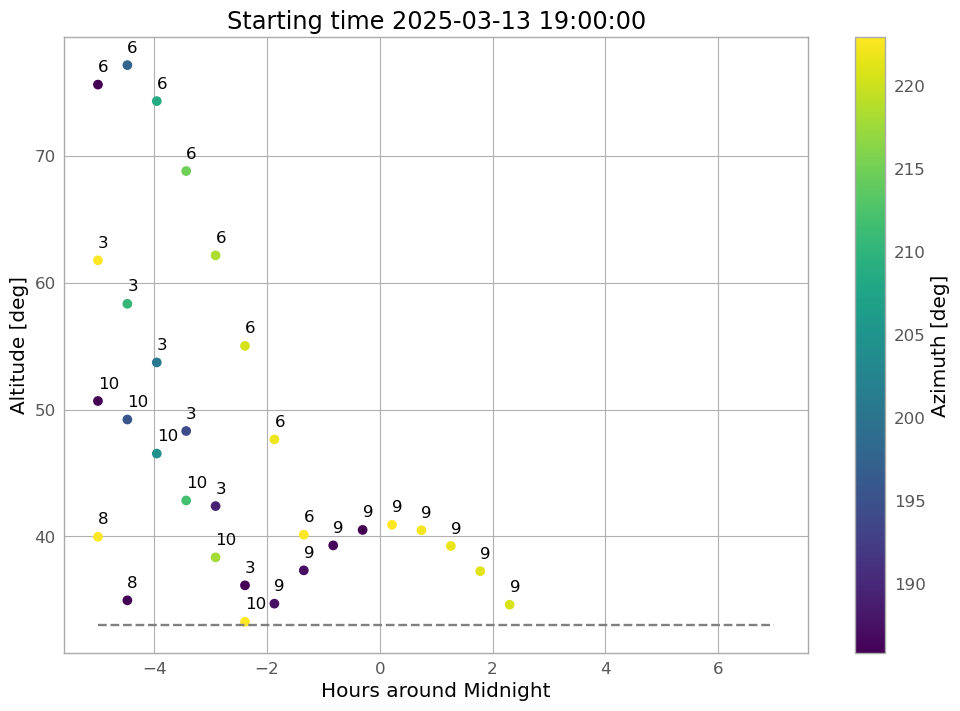

In [6]:
plt.figure(figsize=(12,8))
plt.style.use(astropy_mpl_style)
quantity_support()

for each in graphic:

    label = str(each['Label'].iloc[0])
    ALT = each['Alt'].tolist()
    AZ = each['Az'].tolist()
    T = each['Time'].tolist()

    plt.scatter(T, ALT,c=AZ,cmap="viridis",lw=1)

    for j, alt in enumerate(ALT):
        plt.annotate(label, (T[j], alt + 1), color='k')
        


# Limits of good observations
plt.plot(time, [limit] * len(time), '--', color='grey')
#Details
plt.colorbar().set_label("Azimuth [deg]")
plt.xlabel("Hours around Midnight")
plt.ylabel("Altitude [deg]")
plt.title('Starting time {}'.format(date_i))
plt.show()

In [7]:
print('Which are observables')
observable_alerts

Which are observables


,Name,RA,DEC,Label,Observable
0,EIGMVWOKI,14h02m31.44s,+89d56m58.49s,1,False
1,AGFPSSBBUC,08h29m48.51s,-61d20m29.13s,2,False
2,BVXQBDF,00h41m33.33s,+30d45m48.48s,3,True
3,MSKJKUWSQ,19h54m15.15s,+00d48m54.46s,4,False
4,SIVCM,17h47m00.20s,+70d34m30.59s,5,False
5,YIIGY,01h51m31.77s,-08d15m47.52s,6,True
6,HRQQECNCU,13h01m26.28s,-80d58m53.85s,7,False
7,PLTUMCMW,22h51m26.27s,+40d47m26.39s,8,True
8,ZISBJBUR,06h37m46.39s,+53d42m40.39s,9,True
9,MFXEPTL,01h07m19.31s,-34d36m39.27s,10,True


In [8]:
print('Order for observation')
order_alerts

Order for observation


,Name,RA,DEC,Label
0,YIIGY,01h51m31.77s,-08d15m47.52s,6
1,BVXQBDF,00h41m33.33s,+30d45m48.48s,3
2,MFXEPTL,01h07m19.31s,-34d36m39.27s,10
3,ZISBJBUR,06h37m46.39s,+53d42m40.39s,9
4,PLTUMCMW,22h51m26.27s,+40d47m26.39s,8


## 100 random targets

In [21]:
#Dataframe with random targets
alerts100 = random_data(100)

#Amount of targets, this is for the labels of graphic
many100 = len(alerts100) + 1

#Observations with the data
Data100 = Observations(observer, alerts, date_i, date_f,timescale,many,limit)
time100 = DeltaTime(date_i,date_f,timescale)
order100, observable_alerts100, order_alerts100,graphic100 = EstablishLimits(Data,many,time)

alerts100

,Name,RA,DEC
0,PQBYYHT,14h56m46.94s,+41d04m35.29s
1,IAIIL,02h59m37.76s,+39d11m02.37s
2,QFLYBQE,00h00m17.16s,-61d52m11.51s
3,BEPEGUZB,14h56m06.75s,+67d55m43.50s
4,LJZOZPVRH,00h09m18.37s,+33d35m06.63s
...,...,...,...
95,CPKVRYAHQ,05h39m39.73s,+21d59m22.42s
96,BONOYDCOQ,08h49m39.54s,-69d25m05.77s
97,GLJGMOCMMK,11h06m46.65s,-03d31m20.55s
98,NEZKXNIZ,18h03m27.83s,+70d11m51.21s


In [22]:
print('Which are observables')
observable_alerts100

Which are observables


,Name,RA,DEC,Label,Observable
0,LTLKWBZGHG,14h26m29.16s,-20d19m53.26s,1,True
1,DUCMUOFPA,02h51m29.54s,+29d15m19.27s,2,True
2,WYFYG,03h24m46.44s,-31d51m11.09s,3,True
3,CTLOHSOWIT,09h49m55.29s,-86d56m41.01s,4,False
4,NNCYIUQNIQ,22h09m05.52s,+71d28m13.48s,5,False
...,...,...,...,...,...
995,WZDKTSJQI,19h21m55.10s,-23d18m42.06s,996,False
996,ABVJAZI,07h52m09.97s,-13d43m54.19s,997,True
997,WCDMFX,00h44m38.06s,-52d13m51.73s,998,False
998,MSWGBM,21h40m08.77s,-85d45m50.63s,999,False


In [23]:
print('Order for observation')
order_alerts100

Order for observation


,Name,RA,DEC,Label
0,YQNRPNAJYC,12h56m13.81s,+04d15m12.41s,70
1,TJIBOGOTO,09h19m40.40s,+04d20m10.34s,250
2,ESRYTIFIC,10h47m19.24s,+03d31m13.33s,176
3,ZCHMJPP,06h44m08.21s,+05d22m04.86s,915
4,NCJXT,01h20m20.31s,+02d39m11.73s,883
...,...,...,...,...
487,OWNJB,03h34m34.11s,-52d11m22.76s,809
488,YQVTBTIGK,08h59m03.94s,-52d03m02.81s,941
489,UZOCBLYB,03h52m29.80s,+61d21m44.76s,255
490,DMDGOLUMPW,21h38m48.72s,-01d50m04.62s,26


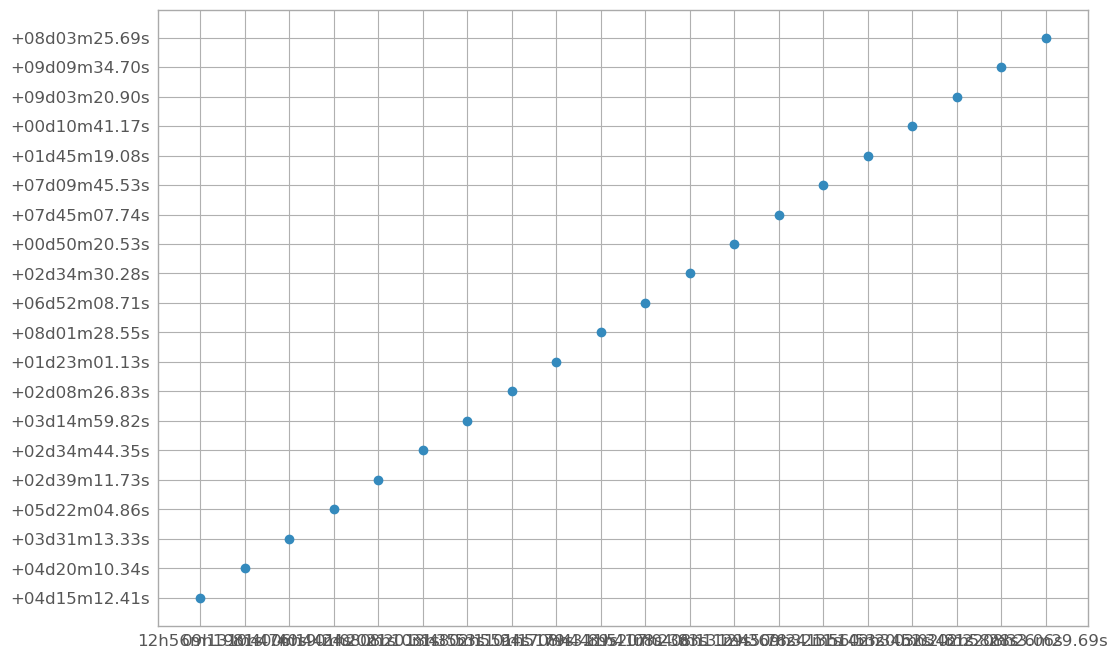

In [25]:
plt.figure(figsize=(12,8))
plt.style.use(astropy_mpl_style)
quantity_support()

plt.scatter(order_alerts['RA'][0:20],order_alerts['DEC'][0:20])

## 1000 random targets

In [13]:
#Dataframe with random targets
alerts = random_data(1000)

#Amount of targets, this is for the labels of graphic
many = len(alerts) + 1

#Observations with the data
Data = Observations(observer, alerts, date_i, date_f,timescale,many,limit)
time = DeltaTime(date_i,date_f,timescale)
order, observable_alerts, order_alerts,graphic = EstablishLimits(Data,many,time)

alerts

,Name,RA,DEC,Label,Observable,Az,Alt
0,LTLKWBZGHG,14h26m29.16s,-20d19m53.26s,1,True,150.229549,60.989407
1,DUCMUOFPA,02h51m29.54s,+29d15m19.27s,2,False,330.411984,-50.423945
2,WYFYG,03h24m46.44s,-31d51m11.09s,3,False,221.859528,-51.343609
3,CTLOHSOWIT,09h49m55.29s,-86d56m41.01s,4,False,182.428845,-2.950470
4,NNCYIUQNIQ,22h09m05.52s,+71d28m13.48s,5,False,14.055296,-7.314034
...,...,...,...,...,...,...,...
995,WZDKTSJQI,19h21m55.10s,-23d18m42.06s,996,False,113.285889,-0.691742
996,ABVJAZI,07h52m09.97s,-13d43m54.19s,997,False,255.690540,4.945819
997,WCDMFX,00h44m38.06s,-52d13m51.73s,998,False,171.256810,-41.699467
998,MSWGBM,21h40m08.77s,-85d45m50.63s,999,False,176.377632,-7.050606


In [14]:
print('Which are observables')
observable_alerts

Which are observables


,Name,RA,DEC,Label,Observable
0,LTLKWBZGHG,14h26m29.16s,-20d19m53.26s,1,True
1,DUCMUOFPA,02h51m29.54s,+29d15m19.27s,2,True
2,WYFYG,03h24m46.44s,-31d51m11.09s,3,True
3,CTLOHSOWIT,09h49m55.29s,-86d56m41.01s,4,False
4,NNCYIUQNIQ,22h09m05.52s,+71d28m13.48s,5,False
...,...,...,...,...,...
995,WZDKTSJQI,19h21m55.10s,-23d18m42.06s,996,False
996,ABVJAZI,07h52m09.97s,-13d43m54.19s,997,True
997,WCDMFX,00h44m38.06s,-52d13m51.73s,998,False
998,MSWGBM,21h40m08.77s,-85d45m50.63s,999,False


In [15]:
print('Order for observation')
order_alerts

Order for observation


,Name,RA,DEC,Label
0,YQNRPNAJYC,12h56m13.81s,+04d15m12.41s,70
1,TJIBOGOTO,09h19m40.40s,+04d20m10.34s,250
2,ESRYTIFIC,10h47m19.24s,+03d31m13.33s,176
3,ZCHMJPP,06h44m08.21s,+05d22m04.86s,915
4,NCJXT,01h20m20.31s,+02d39m11.73s,883
...,...,...,...,...
487,OWNJB,03h34m34.11s,-52d11m22.76s,809
488,YQVTBTIGK,08h59m03.94s,-52d03m02.81s,941
489,UZOCBLYB,03h52m29.80s,+61d21m44.76s,255
490,DMDGOLUMPW,21h38m48.72s,-01d50m04.62s,26
